## England, John | DSA 587 | Final Project Workbook #1
---
This python notebook serves to test out differnet parameters in the SARIMA model. Shown in this workbook are 4 different combinations of the SARIMA model, each featuring different model parameters. When one of these models is run, 3 csvs are output and can be loaded into workbook #2 to lead visualizations. These models are referenced in the presentation as well as the grid search function.


### Import Libraries, Load Data, Pre-Process Data, and ARIMA

In [1]:
# Import Libraries
import os
import sys
import time
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
from scipy.stats import norm
import matplotlib.pyplot as plt

# sklearn library
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.feature_selection import RFECV, SelectFromModel, SelectKBest
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

# statsmodels library
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

# Enable Matplotlib Inline Plotting
%matplotlib inline

# Preset Matplotlib Figure Sizes and Font Sizes
plt.rcParams['figure.figsize'] = (25.0, 15.0)
title_font, label_font, legend_font = 14, 14, 12

# Filepaths 
etf = pd.read_csv(os.path.join("data", "etf_data.csv")) # Vanguard ETFs 
spy = pd.read_csv(os.path.join("data", "spy_data.csv")) # SPDR S&P 500 ETF Trust (SPY)
gdp = pd.read_csv(os.path.join("data", "gdp_data.csv")) # U.S Gross Domestic Product

# DateTime Dates
etf['date'] = pd.to_datetime(etf['date'])
spy['date'] = pd.to_datetime(spy['date'])

# Merged dfs
merged_df = pd.merge(etf, spy, on='date', how='inner')

# Assuming both 'date' columns are in datetime format
etf['date'] = pd.to_datetime(etf['date'])
spy['date'] = pd.to_datetime(spy['date'])

# Merge the DataFrames on the 'date' column
price = pd.merge(etf, spy, on='date', how='inner')

# Set Index
price.set_index('date', inplace=True)

# Set Tickers
tickers = ['VUG','VTV','SPY']

# Empty df for Cumulative Returns
cum_returns = pd.DataFrame()

# Calculate Cumulative Returns
for i in tickers:
    ini_price = price[price[i].notna()][i].iloc[0] # Find the first valid price
    cum_returns[i] = price[i]/ini_price 

# Return DataFrame
cum_returns = cum_returns.sort_index(axis=0,ascending=True)

# ARIMA
cum_returns_df = cum_returns.reset_index()
cum_returns_df['date'] = pd.to_datetime(cum_returns_df['date'])

# Setting the 'date' column as the index
cum_returns_df.set_index('date', inplace=True)

# First, we check if the SPY series is stationary
result = adfuller(cum_returns_df['SPY'])

# Outputting the results of the stationarity check
print(f'ADF Statistic for SPY: {result[0]}')
print(f'p-value for SPY: {result[1]}')

ADF Statistic for SPY: 1.5614100020153021
p-value for SPY: 0.9977370579929439


The results you've mentioned from a stationarity check using the Augmented Dickey-Fuller (ADF) test on the SPY (S&P 500 ETF) dataset can be interpreted as follows:

ADF Statistic: The ADF statistic value for SPY is 1.5614100020153021. This value is compared against critical values for the test at different levels of confidence (usually 1%, 5%, and 10%). A more negative ADF statistic suggests stronger evidence against the null hypothesis, which states that the series has a unit root (is non-stationary).
p-value: The p-value for the test is 0.9977370579929439. This p-value indicates the probability of observing the ADF statistic if the null hypothesis were true. In this case, the p-value is very high, nearly 1, which suggests that the probability of obtaining such a statistic under the null hypothesis is extremely high.
Conclusion:
Given the high p-value (close to 1) and the ADF statistic that is not significantly negative, we fail to reject the null hypothesis that SPY has a unit root, meaning there is strong statistical evidence that the SPY price series is non-stationary. This implies that the series may exhibit trends, random walks, or other characteristics that suggest it can change over time in its mean and variance.

To achieve stationarity, which is often required for time series modeling (like ARIMA), differencing the series or transforming it in other ways (e.g., logarithmic transformation) might be necessary. This process helps in stabilizing the mean of the time series by removing changes in the level of a time series, thereby stabilizing variance as well.

### SAARIMA: Seasonal Auto Regressive Moving Average

####  SARIMA M01

In [ ]:
# SARIMA Model 01: VTV 2023-02-10 to 2024-02-16

# Extract the training and testing data from cumulative returns.
train_vtv_2024 = cum_returns['VTV']['2004-02-06':'2023-02-09']
test_vtv_2024 = cum_returns['VTV']['2023-02-10':'2024-02-16']

# Initialize the SARIMA model with specified orders and seasonal orders
model_vtv_m01 = SARIMAX(train_vtv_2024, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))
results_vtv_m01 = model_vtv_m01.fit() # Fit the SARIMA model to the training data
forecast_vtv_m01 = results_vtv_m01.get_forecast(steps=len(test_vtv_2024)).predicted_mean # Forecast using the fitted model for the length of the test dataset
confidence_intervals_vtv_m01 = results_vtv_m01.get_forecast(steps=len(test_vtv_2024)).conf_int() # Get confidence intervals of the forecasts
confidence_intervals_vtv_m01['forecast'] = forecast_vtv_m01 # Add the forecast to the DataFrame of confidence intervals for easier analysis

# Save Model Forecast, training data, and testing data
confidence_intervals_vtv_m01.to_csv('models/vtv_m01.csv', index=False) # Save the forecast with confidence intervals to a CSV file without the index
train_vtv_2024.to_csv('models/vtv_m01_train.csv', index=True) # Save the training data to a CSV file with the index
test_vtv_2024.to_csv('models/vtv_m01_test.csv', index=True) # Save the test data to a CSV file with the index

In [ ]:
# SARIMA Model 01: VUG 2023-02-10 to 2024-02-16

# Extract the training and testing data from cumulative returns.
train_vug_2024 = cum_returns['VUG']['2004-02-06':'2023-02-09']
test_vug_2024 = cum_returns['VUG']['2023-02-10':'2024-02-16']

# Initialize the SARIMA model with specified orders and seasonal orders
model_vug_m01 = SARIMAX(train_vug_2024, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))
results_vug_m01 = model_vug_m01.fit() # Fit the SARIMA model to the training data
forecast_vug_m01 = results_vug_m01.get_forecast(steps=len(test_vug_2024)).predicted_mean # Forecast using the fitted model for the length of the test dataset
confidence_intervals_vug_m01 = results_vug_m01.get_forecast(steps=len(test_vug_2024)).conf_int() # Get confidence intervals of the forecasts
confidence_intervals_vug_m01['forecast'] = forecast_vug_m01 # Add the forecast to the DataFrame of confidence intervals for easier analysis

# Save Model Forecast, training data, and testing data
confidence_intervals_vug_m01.to_csv('models/vug_m01.csv', index=False) # Save the forecast with confidence intervals to a CSV file without the index
train_vug_2024.to_csv('models/vug_m01_train.csv', index=True) # Save the training data to a CSV file with the index
test_vug_2024.to_csv('models/vug_m01_test.csv', index=True) # Save the test data to a CSV file with the index

In [ ]:
# SARIMA Model 01: SPY 2023-02-10 to 2024-02-16

# Extract the training and testing data from cumulative returns.
train_spy_2024 = cum_returns['SPY']['2004-02-06':'2023-02-09']
test_spy_2024 = cum_returns['SPY']['2023-02-10':'2024-02-16']

# Initialize the SARIMA model with specified orders and seasonal orders
model_spy_m01 = SARIMAX(train_spy_2024, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))
results_spy_m01 = model_spy_m01.fit() # Fit the SARIMA model to the training data
forecast_spy_m01 = results_spy_m01.get_forecast(steps=len(test_spy_2024)).predicted_mean # Forecast using the fitted model for the length of the test dataset
confidence_intervals_spy_m01 = results_spy_m01.get_forecast(steps=len(test_spy_2024)).conf_int() # Get confidence intervals of the forecasts
confidence_intervals_spy_m01['forecast'] = forecast_spy_m01 # Add the forecast to the DataFrame of confidence intervals for easier analysis

# Save Model Forecast, training data, and testing data
confidence_intervals_spy_m01.to_csv('models/spy_m01.csv', index=False) # Save the forecast with confidence intervals to a CSV file without the index
train_spy_2024.to_csv('models/spy_m01_train.csv', index=True) # Save the training data to a CSV file with the index
test_spy_2024.to_csv('models/spy_m01_test.csv', index=True) # Save the test data to a CSV file with the index


In [ ]:
###########################################################
#   For SARIMA Visualizations please see other notebook   #
###########################################################

#### Seasonal Decomposition Plots

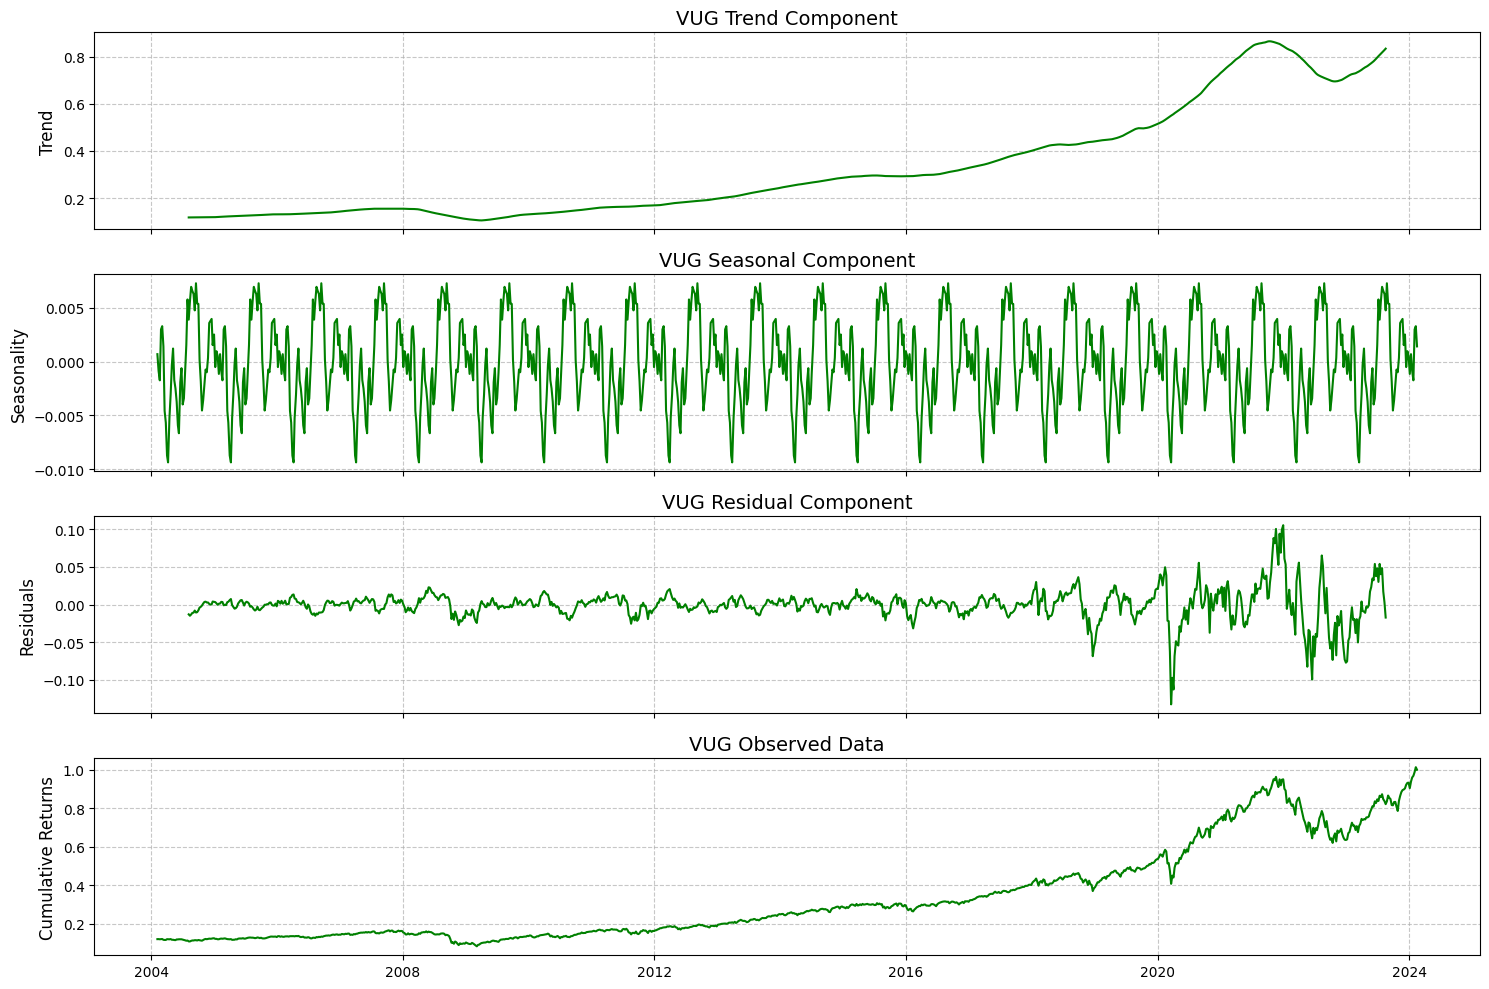

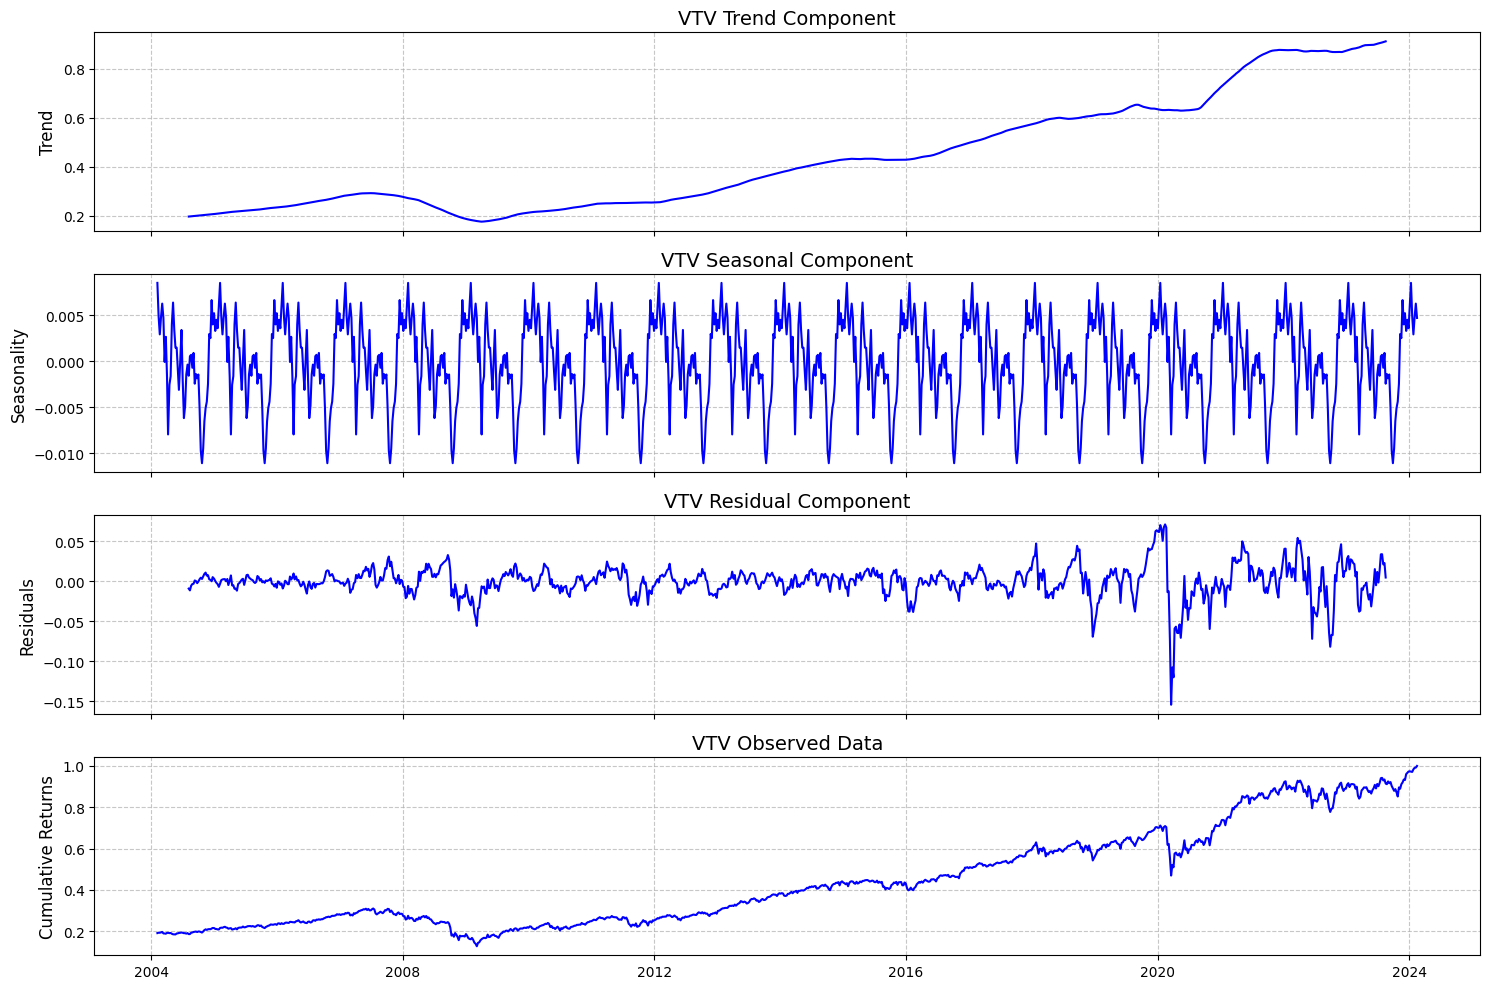

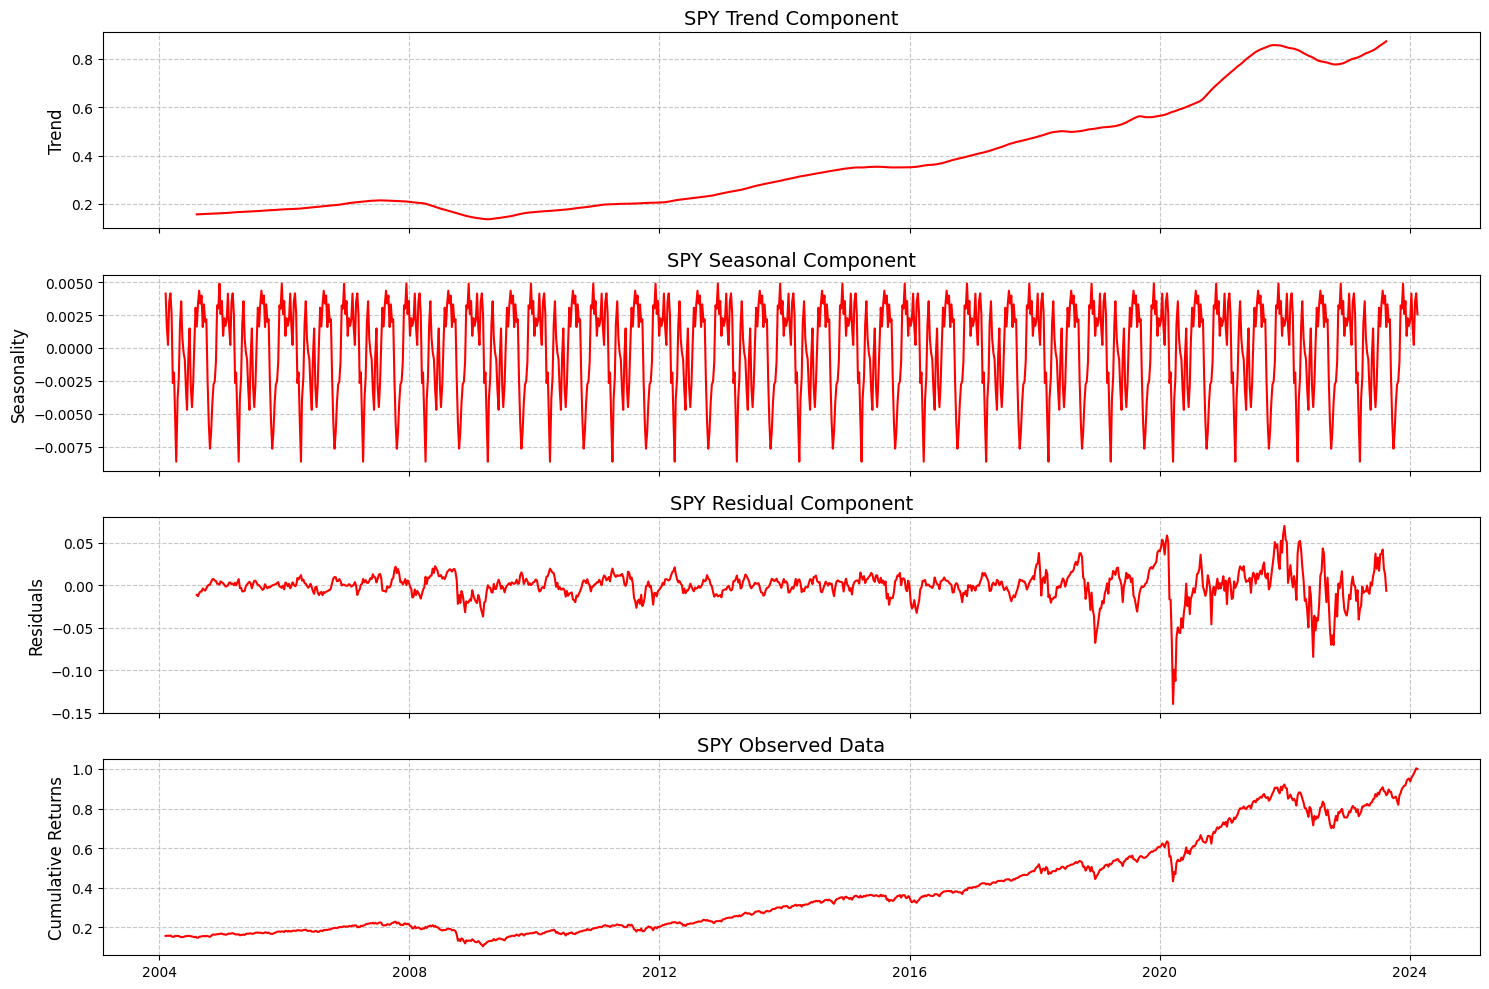

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose each ETF time series
etfs = ['VUG', 'VTV', 'SPY']
colors = {'VUG': 'green', 'VTV': 'blue', 'SPY': 'red'}

for etf in etfs:
    # Seasonal decomposition
    decomposition = seasonal_decompose(cum_returns[etf], model='additive', period=52)  # Assuming weekly data, period=52 weeks in a year
    fig, ax = plt.subplots(4, 1, figsize=(15, 10), sharex=True)

    # Trend component plot
    ax[0].plot(decomposition.trend, color=colors[etf])
    ax[0].set_title(f'{etf} Trend Component', fontsize=14)
    ax[0].set_ylabel('Trend', fontsize=12)
    ax[0].grid(True, linestyle='--', alpha=0.7)  # Custom grid style

    # Seasonal component plot
    ax[1].plot(decomposition.seasonal, color=colors[etf])
    ax[1].set_title(f'{etf} Seasonal Component', fontsize=14)
    ax[1].set_ylabel('Seasonality', fontsize=12)
    ax[1].grid(True, linestyle='--', alpha=0.7)

    # Residual component plot
    ax[2].plot(decomposition.resid, color=colors[etf])
    ax[2].set_title(f'{etf} Residual Component', fontsize=14)
    ax[2].set_ylabel('Residuals', fontsize=12)
    ax[2].grid(True, linestyle='--', alpha=0.7)

    # Observed data plot
    ax[3].plot(cum_returns[etf], color=colors[etf])
    ax[3].set_title(f'{etf} Observed Data', fontsize=14)
    ax[3].set_ylabel('Cumulative Returns', fontsize=12)
    ax[3].grid(True, linestyle='--', alpha=0.7)

    # Adjust layout to make room for plot labels
    plt.tight_layout()
    plt.show()


#### A Closer Investigation of the Seasonal Decomposition Plots

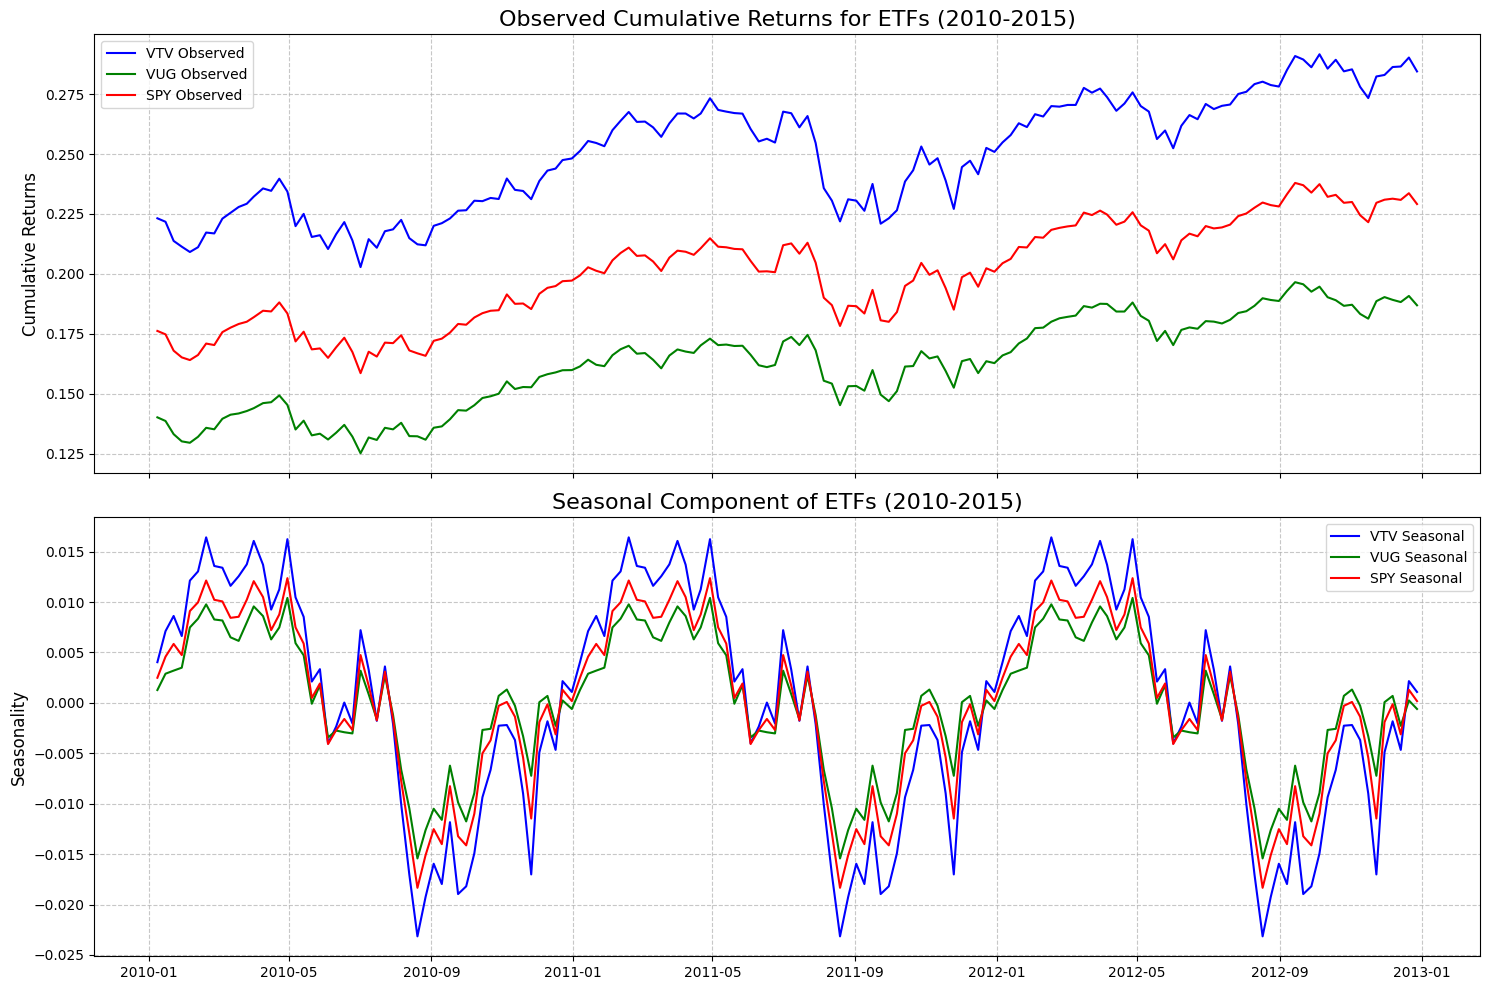

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

cum_returns_2010_2015_vtv = cum_returns['VTV']['2010-01-01':'2012-12-31'].to_frame()
cum_returns_2010_2015_vug = cum_returns['VUG']['2010-01-01':'2012-12-31'].to_frame()
cum_returns_2010_2015_spy = cum_returns['SPY']['2010-01-01':'2012-12-31'].to_frame()
merged_2010_2015 = pd.concat([cum_returns_2010_2015_vtv, cum_returns_2010_2015_vug, cum_returns_2010_2015_spy], axis=1)

# Decompose each ETF time series
etfs = ['VTV', 'VUG', 'SPY']
colors = {'VUG': 'green', 'VTV': 'blue', 'SPY': 'red'}
fig, ax = plt.subplots(2, 1, figsize=(15, 10), sharex=True)  # Two subplots, shared x-axis

for etf in etfs:
    # Seasonal decomposition
    decomposition = seasonal_decompose(merged_2010_2015[etf], model='additive', period=52)  # Assuming weekly data
    
    # Plot observed data for each ETF
    ax[0].plot(merged_2010_2015.index, merged_2010_2015[etf], label=f'{etf} Observed', color=colors[etf])

    # Plot seasonal component for each ETF
    ax[1].plot(decomposition.seasonal, label=f'{etf} Seasonal', color=colors[etf])

# Set titles and labels
ax[0].set_title('Observed Cumulative Returns for ETFs (2010-2015)', fontsize=16)
ax[0].set_ylabel('Cumulative Returns', fontsize=12)
ax[0].grid(True, linestyle='--', alpha=0.7)
ax[0].legend()  # Add legend to differentiate ETFs

ax[1].set_title('Seasonal Component of ETFs (2010-2015)', fontsize=16)
ax[1].set_ylabel('Seasonality', fontsize=12)
ax[1].grid(True, linestyle='--', alpha=0.7)
ax[1].legend()  # Add legend to differentiate ETFs

# Tight layout to adjust spacing between plots
plt.tight_layout()
plt.show()


#### Parameter Grid Search

In [4]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
# Define the parameter grid
p = d = q = range(0, 2)  # Non-seasonal parameters
sp = sd = sq = range(0, 2)  # Seasonal parameters
s = 52  # Weekly seasonality

# Generate all different combinations of p, d, q and seasonal p, d, q
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], s) for x in list(itertools.product(sp, sd, sq))]

# DataFrame to store results
results_df = pd.DataFrame(columns=['param', 'param_seasonal', 'aic'])

# Load your data
# cum_returns = pd.read_csv('path_to_file.csv', index_col='date', parse_dates=True)
# Train data (replace 'VTV' with the ETF you're analyzing)
train_data = cum_returns['VTV']['2004-02-06':'2023-02-09']

best_aic = float('inf')
best_param = None
best_seasonal_param = None

# Grid search
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(train_data,
                          order=param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

            results = mod.fit()

            # Compare AIC values
            if results.aic < best_aic:
                best_aic = results.aic
                best_param = param
                best_seasonal_param = param_seasonal

            # Store results
            results_df = results_df.append({'param': param, 'param_seasonal': param_seasonal, 'aic': results.aic}, ignore_index=True)
        except:
            continue

# Print out the best parameters and AIC
print(f"Best SARIMA{best_param}x{best_seasonal_param} - AIC:{best_aic}")

# Sort and view results
results_df.sort_values('aic', inplace=True)
print(results_df.head())


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.61648D-01    |proj g|=  1.74903D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2     14      1     0     0   4.515D-05   6.616D-01
  F =  0.66164745093892963     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.96565D-01    |proj g|=  1.37421D+00


 This problem is unconstrained.



At iterate    5    f=  1.18930D-01    |proj g|=  2.98975D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     54      2     0     0   2.407D-05   1.189D-01
  F =  0.11891310856486553     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.10903D+00    |proj g|=  7.29412D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      4      7      1     0     0   1.455D-06  -1.110D+00
  F =  -1.1097505112804431     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.01112D+00    |proj g|=  6.71038D-01


 This problem is unconstrained.



At iterate    5    f= -1.02511D+00    |proj g|=  1.64881D+00

At iterate   10    f= -1.03237D+00    |proj g|=  2.99348D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     28      1     0     0   3.338D-05  -1.032D+00
  F =  -1.0323736269301940     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.26687D+00    |proj g|=  2.34550D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     15      1     0     0   2.345D-03  -1.267D+00
  F =  -1.2668660390284898     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.32212D+00    |proj g|=  3.34160D+00


 This problem is unconstrained.



At iterate    5    f= -1.34308D+00    |proj g|=  1.26595D-01

At iterate   10    f= -1.35321D+00    |proj g|=  9.79396D-01

At iterate   15    f= -1.35480D+00    |proj g|=  1.50597D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     21      1     0     0   1.154D-04  -1.355D+00
  F =  -1.3547969027607698     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.03569D+00    |proj g|=  1.54607D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     16      1     0     0   1.546D-03  -1.036D+00
  F =  -1.0356932899422335     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.01461D+00    |proj g|=  6.32983D-01

At iterate    5    f= -1.03115D+00    |proj g|=  7.44077D-01

At iterate   10    f= -1.03212D+00    |proj g|=  5.36211D-02

At iterate   15    f= -1.03344D+00    |proj g|=  8.57962D-01

At iterate   20    f= -1.08035D+00    |proj g|=  2.65570D-01

At iterate   25    f= -1.09637D+00    |proj g|=  2.55310D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     64      1     0     0   1.926D-04  -1.096D+00
  F =  -1.0964546471736802     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.97035D-01    |proj g|=  1.55864D+00

At iterate    5    f= -1.19114D-02    |proj g|=  3.01285D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     16      1     0     0   1.510D-04  -1.193D-02
  F =  -1.1926605634657002E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.46751D-01    |proj g|=  1.84227D+00


 This problem is unconstrained.



At iterate    5    f= -4.98189D-01    |proj g|=  8.98796D-02

At iterate   10    f= -4.99195D-01    |proj g|=  9.67189D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     20      1     0     0   9.672D-06  -4.992D-01
  F = -0.49919541907414477     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.40523D+00    |proj g|=  7.65827D+00

At iterate    5    f= -1.62931D+00    |proj g|=  7.31764D-01

At iterate   10    f= -1.63447D+00    |proj g|=  1.66950D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     10     15      1     0     0   1.669D-05  -1.634D+00
  F =  -1.6344688986195881     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.29541D+00    |proj g|=  6.35383D+00


 This problem is unconstrained.



At iterate    5    f= -1.49159D+00    |proj g|=  8.75960D-01

At iterate   10    f= -1.52153D+00    |proj g|=  2.72555D-01

At iterate   15    f= -1.52317D+00    |proj g|=  5.07646D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     28      1     0     0   5.252D-05  -1.523D+00
  F =  -1.5231720837559848     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.59368D-01    |proj g|=  2.00243D+00
  ys=-2.751E+00  -gs= 8.231E-01 BFGS update SKIPPED

At iterate    5    f= -1.75042D+00    |proj g|=  6.76813D-01

At iterate   10    f= -1.76646D+00    |proj g|=  4.78732D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     39      2     1     0   2.489D-04  -1.766D+00
  F =  -1.7664647309239427     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.61764D-01    |proj g|=  2.00066D+00

At iterate    5    f= -1.81259D+00    |proj g|=  4.71484D+00

At iterate   10    f= -1.84440D+00    |proj g|=  1.37397D-01

At iterate   15    f= -1.85427D+00    |proj g|=  1.06852D+00

At iterate   20    f= -1.85980D+00    |proj g|=  2.91125D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     36      1     0     0   2.791D-04  -1.860D+00
  F =  -1.8597953874717290     

CONVERG

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.31540D+00    |proj g|=  6.86091D+00


 This problem is unconstrained.



At iterate    5    f= -1.52000D+00    |proj g|=  4.79257D-01

At iterate   10    f= -1.52711D+00    |proj g|=  5.86819D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     22      1     0     0   1.506D-04  -1.527D+00
  F =  -1.5272218889576490     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.29536D+00    |proj g|=  6.39115D+00

At iterate    5    f= -1.49713D+00    |proj g|=  9.29777D-01

At iterate   10    f= -1.52255D+00    |proj g|=  1.08077D-01

At iterate   15    f= -1.52262D+00    |proj g|=  9.74740D-02
  ys=-1.918E-03  -gs= 5.774E-03 BFGS update SKIPPED

At iterate   20    f= -1.53737D+00    |proj g|=  1.32459D+00

At iterate   25    f= -1.56739D+00    |proj g|=  6.73647D-02

At iterate   30    f= -1.56765D+00    |proj g|=  1.65453D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     72      1     1     0   3.086D-03  -1.568D+00
  F =  -1.5676541354767333     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/ba

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.08289D+00    |proj g|=  9.77805D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2     14      1     0     0   1.836D-02  -3.083D+00
  F =  -3.0828906824542814     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.89689D+00    |proj g|=  8.35575D+00

At iterate    5    f= -2.89967D+00    |proj g|=  6.85121D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5     11      1     0     0   6.851D-02  -2.900D+00
  F =  -2.8996725464174617     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.66270D+00    |proj g|=  3.81364D+00
  ys=-2.193E-10  -gs= 4.056E-09 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      4     28      1     1     0   3.915D-02  -2.663D+00
  F =  -2.6634511093647402     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.66805D+00    |proj g|=  1.57044D+01

At iterate    5    f= -2.68554D+00    |proj g|=  4.30686D+00

At iterate   10    f= -2.69117D+00    |proj g|=  3.00986D-04
  ys=-1.586E-10  -gs= 5.294E-11 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     12     53      2     1     0   2.155D-03  -2.691D+00
  F =  -2.6911730584602793     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.90399D+00    |proj g|=  7.45990D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     18      1     0     0   7.460D-02  -2.904D+00
  F =  -2.9039934455444585     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.89796D+00    |proj g|=  8.21415D+00

At iterate    5    f= -2.90063D+00    |proj g|=  6.84837D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6     13      1     0     0   5.367D-02  -2.901D+00
  F =  -2.9006334820037130     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.62027D+00    |proj g|=  5.59733D-02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1      9      1     0     0   5.319D-02  -2.620D+00
  F =  -2.6202675383067211     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.65127D+00    |proj g|=  9.46697D+00

At iterate    5    f= -2.65611D+00    |proj g|=  2.80517D-01

At iterate   10    f= -2.65736D+00    |proj g|=  4.79400D+00

At iterate   15    f= -2.66983D+00    |proj g|=  9.68280D-01

At iterate   20    f= -2.67236D+00    |proj g|=  6.42253D+00

At iterate   25    f= -2.68089D+00    |proj g|=  7.19642D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     34      1     0     0   

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/ba

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.08020D+00    |proj g|=  2.59691D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      6      1     0     0   1.628D-04  -3.080D+00
  F =  -3.0801999003374103     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.8

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3     26      1     0     0   3.210D-02  -2.897D+00
  F =  -2.8968422789865507     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.66044D+00    |proj g|=  1.84140D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2     20      1     0     0   1.735D-02  -2.660D+00
  F =  -2.6604388303725131     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.64986D+00    |proj g|=  2.01900D+01

At iterate    5    f= -2.68076D+00    |proj g|=  1.19304D-01

At iterate   10    f= -2.68110D+00    |proj g|=  2.55434D+00

At iterate   15    f= -2.68843D+00    |proj g|=  2.97616D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     33      1     0     0   7.343D-03  -2.689D+00
  F =  -2.6888061236242828     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.90436D+00    |proj g|=  3.39691D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3     18      1     0     0   2.164D-02  -2.905D+00
  F =  -2.9047398872340233     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.89742D+00    |proj g|=  3.49660D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      3     14      1     0     0   2.508D-02  -2.898D+00
  F =  -2.8978239919226789     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.61030D+00    |proj g|=  1.28440D+01


 This problem is unconstrained.



At iterate    5    f= -2.62151D+00    |proj g|=  1.09520D-01

At iterate   10    f= -2.62183D+00    |proj g|=  1.46650D+00

At iterate   15    f= -2.62206D+00    |proj g|=  6.14322D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     50      2     0     0   5.835D-03  -2.622D+00
  F =  -2.6220592312609341     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.63231D+00    |proj g|=  1.72641D+01

At iterate    5    f= -2.65394D+00    |proj g|=  9.97079D-02

At iterate   10    f= -2.65432D+00    |proj g|=  2.84645D+00

At iterate   15    f= -2.66655D+00    |proj g|=  4.45283D+00

At iterate   20    f= -2.66743D+00    |proj g|=  9.72306D-01

At iterate   25    f= -2.67286D+00    |proj g|=  7.96672D+00

At iterate   30    f= -2.67891D+00    |proj g|=  1.83103D-02

At iterate   35    f= -2.67900D+00    |proj g|=  4.58314D-02

At iterate   40    f= -2.67900D+00    |proj g|=  6.03030D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(date

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.08868D+00    |proj g|=  8.25809D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     20      1     0     0   8.258D-02  -3.089D+00
  F =  -3.0886811172709150     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.92419D+00    |proj g|=  1.72795D+02

At iterate    5    f= -2.42115D+00    |proj g|=  4.67426D+00

At iterate   10    f= -2.89630D+00    |proj g|=  4.46878D+00

At iterate   15    f= -2.90493D+00    |proj g|=  1.83547D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     42      1     0     0   1.835D-02  -2.905D+00
  F =  -2.9049348910257522     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.67125D+00    |proj g|=  4.82642D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2     19      1     0     0   3.813D-02  -2.671D+00
  F =  -2.6712480849475089     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.30329D+00    |proj g|=  3.04647D+01

At iterate    5    f= -2.34993D+00    |proj g|=  5.39361D+00

At iterate   10    f= -2.47932D+00    |proj g|=  1.53319D+00

At iterate   15    f= -2.57864D+00    |proj g|=  2.32697D+01

At iterate   20    f= -2.69401D+00    |proj g|=  1.43994D+00

At iterate   25    f= -2.69461D+00    |proj g|=  6.55709D-02
  ys=-3.948E-10  -gs= 5.136E-09 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Proj


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.51106D+00    |proj g|=  7.53918D+01

At iterate    5    f= -2.62860D+00    |proj g|=  4.80894D-01

At iterate   10    f= -2.63462D+00    |proj g|=  8.65264D+00

At iterate   15    f= -2.64895D+00    |proj g|=  6.27065D-01

At iterate   20    f= -2.65882D+00    |proj g|=  1.07127D+01

At iterate   25    f= -2.81413D+00    |proj g|=  2.97824D+01

At iterate   30    f= -2.90555D+00    |proj g|=  5.75675D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.71243D+00    |proj g|=  3.82474D+01

At iterate    5    f= -2.74927D+00    |proj g|=  7.55906D-01

At iterate   10    f= -2.76492D+00    |proj g|=  9.61098D+00

At iterate   15    f= -2.82644D+00    |proj g|=  4.40411D+00

At iterate   20    f= -2.89336D+00    |proj g|=  7.57482D-02

At iterate   25    f= -2.89352D+00    |proj g|=  5.31379D-01

At iterate   30    f= -2.89979D+00    |proj g|=  3.07230D+00

At iterate   35    f= -2.90592D+00    |proj g|=  1.39346D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.43303D+00    |proj g|=  1.24901D+01


 This problem is unconstrained.



At iterate    5    f= -2.44295D+00    |proj g|=  4.68524D+00

At iterate   10    f= -2.53719D+00    |proj g|=  1.55502D+00

At iterate   15    f= -2.61144D+00    |proj g|=  4.32288D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     64      2     0     0   7.446D-03  -2.622D+00
  F =  -2.6222789627572785     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency in

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.32091D+00    |proj g|=  2.79268D+01


 This problem is unconstrained.



At iterate    5    f= -2.35820D+00    |proj g|=  3.29647D+00

At iterate   10    f= -2.50186D+00    |proj g|=  2.25584D+01

At iterate   15    f= -2.53643D+00    |proj g|=  7.69801D+00

At iterate   20    f= -2.64413D+00    |proj g|=  7.21921D+00

At iterate   25    f= -2.65775D+00    |proj g|=  6.69107D-02

At iterate   30    f= -2.65851D+00    |proj g|=  2.39349D+00

At iterate   35    f= -2.67780D+00    |proj g|=  4.33256D+00

At iterate   40    f= -2.68426D+00    |proj g|=  1.87972D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     44     84      2     0     0   2.274D-04  -2.684D+00
  F =  -2.6842670366172809     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(date

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.08630D+00    |proj g|=  2.64948D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2      6      1     0     0   8.388D-03  -3.086D+00
  F =  -3.0862982882588721     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.9

 This problem is unconstrained.



At iterate    5    f= -2.41340D+00    |proj g|=  5.77888D+00

At iterate   10    f= -2.89220D+00    |proj g|=  3.99661D+00

At iterate   15    f= -2.90123D+00    |proj g|=  4.58805D-02

At iterate   20    f= -2.90128D+00    |proj g|=  7.84485D-01

At iterate   25    f= -2.90232D+00    |proj g|=  4.56710D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     72      2     0     0   3.548D-02  -2.902D+00
  F =  -2.9023500974545215     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.66805D+00    |proj g|=  1.82697D-01
  ys=-8.426E-12  -gs= 2.532E-09 BFGS update SKIPPED



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3     25      1     1     0   1.736D-02  -2.668D+00
  F =  -2.6680485186889644     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.30035D+00    |proj g|=  3.02561D+01

At iterate    5    f= -2.34598D+00    |proj g|=  5.02844D+00

At iterate   10    f= -2.46268D+00    |proj g|=  1.97137D+00

At iterate   15    f= -2.49256D+00    |proj g|=  1.36841D+01

At iterate   20    f= -2.67690D+00    |proj g|=  4.86124D+00

At iterate   25    f= -2.68874D+00    |proj g|=  8.42626D-02

At iterate   30    f= -2.69216D+00    |proj g|=  2.01104D-02

At iterate   35    f= -2.69217D+00    |proj g|=  1.41640D-02
  ys=-1.010E-09  -gs= 5.746E-10 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.51130D+00    |proj g|=  7.53714D+01

At iterate    5    f= -2.62861D+00    |proj g|=  4.82464D-01

At iterate   10    f= -2.63454D+00    |proj g|=  8.45952D+00

At iterate   15    f= -2.64797D+00    |proj g|=  1.07762D+00

At iterate   20    f= -2.66623D+00    |proj g|=  1.38686D+01

At iterate   25    f= -2.84398D+00    |proj g|=  6.73916D+00

At iterate   30    f= -2.90089D+00    |proj g|=  1.03283D-01

At iterate   35    f= -2.90245D+00    |proj g|=  2.39278D+00

At iterate   40    f= -2.90652D+00    |proj g|=  3.15581D-01

At iterate   45    f= -2.90652D+00    |proj g|=  7.21258D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.71014D+00    |proj g|=  3.80351D+01

At iterate    5    f= -2.74669D+00    |proj g|=  7.90297D-01

At iterate   10    f= -2.76184D+00    |proj g|=  8.84347D+00

At iterate   15    f= -2.77637D+00    |proj g|=  2.52148D+00

At iterate   20    f= -2.87700D+00    |proj g|=  1.38589D+01

At iterate   25    f= -2.89052D+00    |proj g|=  5.74401D-02

At iterate   30    f= -2.89221D+00    |proj g|=  1.13088D+00

At iterate   35    f= -2.89398D+00    |proj g|=  4.53911D-02

At iterate   40    f= -2.90230D+00    |proj g|=  1.34883D+00

At iterate   45    f= -2.90329D+00    |proj g|=  1.95293D-01


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -2.90330D+00    |proj g|=  3.67804D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     64      1     0     0   3.678D-03  -2.903D+00
  F =  -2.9033010599096278     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.43330D+00    |proj g|=  1.22569D+01

At iterate    5    f= -2.44307D+00    |proj g|=  4.54488D+00

At iterate   10    f= -2.53745D+00    |proj g|=  1.23149D+01

At iterate   15    f= -2.60488D+00    |proj g|=  1.36083D+01

At iterate   20    f= -2.62245D+00    |proj g|=  5.18268D-02

At iterate   25    f= -2.62282D+00    |proj g|=  5.13349D-01

At iterate   30    f= -2.62371D+00    |proj g|=  2.34306D-01

At iterate   35    f= -2.62380D+00    |proj g|=  7.35192D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     39     81      2     0     0   8.794D-03  -2.624D+00
  F =  -2.6238055575262407     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.31798D+00    |proj g|=  2.77231D+01

At iterate    5    f= -2.35488D+00    |proj g|=  3.25207D+00

At iterate   10    f= -2.49676D+00    |proj g|=  2.32222D+01

At iterate   15    f= -2.53295D+00    |proj g|=  7.61581D+00

At iterate   20    f= -2.64109D+00    |proj g|=  7.16189D+00

At iterate   25    f= -2.65414D+00    |proj g|=  7.24239D-02

At iterate   30    f= -2.65553D+00    |proj g|=  2.20807D+00

At iterate   35    f= -2.66754D+00    |proj g|=  2.44693D+00

At iterate   40    f= -2.67033D+00    |proj g|=  3.12307D-01

At iterate   45    f= -2.67772D+00    |proj g|=  1.11114D+00


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -2.68228D+00    |proj g|=  7.18085D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     58      1     0     0   7.181D-02  -2.682D+00
  F =  -2.6822835383622312     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.08383D+00    |proj g|=  8.22121D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     21      1     0     0   8.221D-02  -3.084D+00
  F =  -3.0838334373353047     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.89998D+00    |proj g|=  3.86672D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3     46      2     0     0   3.986D-02  -2.900D+00
  F =  -2.9004607444631318     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.66383D+00    |proj g|=  4.52535D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     11      1     0     0   4.514D-02  -2.664D+00
  F =  -2.6638319249974738     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.65360D+00    |proj g|=  2.01528D+01

At iterate    5    f= -2.68421D+00    |proj g|=  1.19102D-01

At iterate   10    f= -2.68451D+00    |proj g|=  2.34718D+00

At iterate   15    f= -2.69171D+00    |proj g|=  3.48467D+00

At iterate   20    f= -2.69223D+00    |proj g|=  7.60889D-04

At iterate   25    f= -2.69223D+00    |proj g|=  2.72257D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f= -2.69223D+00    |proj g|=  4.42837D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     30     72      2     0     0   4.428D-03  -2.692D+00
  F =  -2.6922309687961112     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.90072D+00    |proj g|=  3.75635D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3     46      2     0     0   3.485D-02  -2.901D+00
  F =  -2.9011780254249855     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.90100D+00    |proj g|=  3.67460D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      3     13      1     0     0   3.129D-02  -2.901D+00
  F =  -2.9014426870979815     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.60737D+00    |proj g|=  1.26426D+01

At iterate    5    f= -2.61818D+00    |proj g|=  3.94388D-02

At iterate   10    f= -2.61846D+00    |proj g|=  1.96535D+00

At iterate   15    f= -2.61890D+00    |proj g|=  3.08710D-03
  ys=-2.009E-08  -gs= 8.990E-08 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     45      1     1     0   3.087D-03  -2.619D+00
  F =  -2.6188994743586100     

CONVERGENCE: REL_


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.63602D+00    |proj g|=  1.72179D+01

At iterate    5    f= -2.65741D+00    |proj g|=  9.95255D-02

At iterate   10    f= -2.65779D+00    |proj g|=  2.84252D+00

At iterate   15    f= -2.67004D+00    |proj g|=  4.33124D+00

At iterate   20    f= -2.67085D+00    |proj g|=  2.15423D-01

At iterate   25    f= -2.67739D+00    |proj g|=  4.34438D+00

At iterate   30    f= -2.68235D+00    |proj g|=  2.50475D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(date

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.08027D+00    |proj g|=  2.59249D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3     20      1     0     0   6.526D-05  -3.080D+00
  F =  -3.0802739574915439     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.89653D+00    |proj g|=  3.67738D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      3     21      1     0     0   3.169D-02  -2.897D+00
  F =  -2.8969685755255372     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.66100D+00    |proj g|=  2.07800D-01

At iterate    5    f= -2.66100D+00    |proj g|=  1.63662D-01

At iterate   10    f= -2.66115D+00    |proj g|=  7.96710D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     25      1     0     0   3.178D-02  -2.661D+00
  F =  -2.6611545051440912     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.65022D+00    |proj g|=  2.01919D+01


 This problem is unconstrained.



At iterate    5    f= -2.68110D+00    |proj g|=  1.18481D-01

At iterate   10    f= -2.68149D+00    |proj g|=  2.71529D+00

At iterate   15    f= -2.68843D+00    |proj g|=  1.87356D+00

At iterate   20    f= -2.68919D+00    |proj g|=  4.80634D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     33      1     0     0   9.005D-03  -2.689D+00
  F =  -2.6891943883762157     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.90088D+00    |proj g|=  3.47263D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      3     15      1     0     0   2.411D-02  -2.901D+00
  F =  -2.9012721699624406     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.89757D+00    |proj g|=  3.48363D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      3     15      1     0     0   2.470D-02  -2.898D+00
  F =  -2.8979658474626966     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.60764D+00    |proj g|=  1.28104D+01

At iterate    5    f= -2.61884D+00    |proj g|=  4.31997D-01

At iterate   10    f= -2.62046D+00    |proj g|=  1.09790D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     22      1     0     0   1.131D-02  -2.620D+00
  F =  -2.6204607687474479     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.63283D+00    |proj g|=  1.72900D+01


 This problem is unconstrained.



At iterate    5    f= -2.65452D+00    |proj g|=  9.92624D-02

At iterate   10    f= -2.65510D+00    |proj g|=  3.57019D+00

At iterate   15    f= -2.66252D+00    |proj g|=  5.10125D-01

At iterate   20    f= -2.66282D+00    |proj g|=  1.85469D+00

At iterate   25    f= -2.67196D+00    |proj g|=  3.86967D+00

At iterate   30    f= -2.67332D+00    |proj g|=  2.87430D-01

At iterate   35    f= -2.67926D+00    |proj g|=  8.71346D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     48      1     0     0   3.173D-02  -2.679D+00
  F =  -2.6794853116947674     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

#### SARMA M02

In [ ]:
# SARIMA Model 02: VTV 2023-02-10 to 2024-02-16

# Extract the training and testing data from cumulative returns.
train_vtv_2024 = cum_returns['VTV']['2004-02-06':'2023-02-09']
test_vtv_2024 = cum_returns['VTV']['2023-02-10':'2024-02-16']

# Initialize the SARIMA model with specified orders and seasonal orders
model_vtv_m02 = SARIMAX(train_vtv_2024, order=(1, 0, 0), seasonal_order=(0, 0, 0, 52)) # - AIC:-6123.943336665496
results_vtv_m02 = model_vtv_m02.fit() # Fit the SARIMA model to the training data
forecast_vtv_m02 = results_vtv_m02.get_forecast(steps=len(test_vtv_2024)).predicted_mean # Forecast using the fitted model for the length of the test dataset
confidence_intervals_vtv_m02 = results_vtv_m02.get_forecast(steps=len(test_vtv_2024)).conf_int() # Get confidence intervals of the forecasts
confidence_intervals_vtv_m02['forecast'] = forecast_vtv_m02 # Add the forecast to the DataFrame of confidence intervals for easier analysis

# Save Model Forecast, training data, and testing data
confidence_intervals_vtv_m02.to_csv('models/vtv_m02.csv', index=False) # Save the forecast with confidence intervals to a CSV file without the index
train_vtv_2024.to_csv('models/vtv_m02_train.csv', index=True) # Save the training data to a CSV file with the index
test_vtv_2024.to_csv('models/vtv_m02_test.csv', index=True) # Save the test data to a CSV file with the index

In [ ]:
# SARIMA Model 02: VUG 2023-02-10 to 2024-02-16

# Extract the training and testing data from cumulative returns.
train_vug_2024 = cum_returns['VUG']['2004-02-06':'2023-02-09']
test_vug_2024 = cum_returns['VUG']['2023-02-10':'2024-02-16']

# Initialize the SARIMA model with specified orders and seasonal orders
model_vug_m02 = SARIMAX(train_vug_2024, order=(1, 0, 0), seasonal_order=(0, 0, 0, 52)) # - AIC:-6123.943336665496
results_vug_m02 = model_vug_m02.fit() # Fit the SARIMA model to the training data
forecast_vug_m02 = results_vug_m02.get_forecast(steps=len(test_vug_2024)).predicted_mean # Forecast using the fitted model for the length of the test dataset
confidence_intervals_vug_m02 = results_vug_m02.get_forecast(steps=len(test_vug_2024)).conf_int() # Get confidence intervals of the forecasts
confidence_intervals_vug_m02['forecast'] = forecast_vug_m02 # Add the forecast to the DataFrame of confidence intervals for easier analysis

# Save Model Forecast, training data, and testing data
confidence_intervals_vug_m02.to_csv('models/vug_m02.csv', index=False) # Save the forecast with confidence intervals to a CSV file without the index
train_vug_2024.to_csv('mode als/vug_m02_train.csv', index=True) # Save the training data to a CSV file with the index
test_vug_2024.to_csv('models/vug_m02_test.csv', index=True) # Save the test data to a CSV file with the index

In [ ]:
###########################################################
#   For SARIMA Visualizations please see other notebook   #
###########################################################

# SARIMA Model 02: SPY 2023-02-10 to 2024-02-16

# Extract the training and testing data from cumulative returns.
train_spy_2024 = cum_returns['SPY']['2004-02-06':'2023-02-09']
test_spy_2024 = cum_returns['SPY']['2023-02-10':'2024-02-16']

# Initialize the SARIMA model with specified orders and seasonal orders
model_spy_m02 = SARIMAX(train_spy_2024, order=(1, 0, 0), seasonal_order=(0, 0, 0, 52)) # - AIC:-6123.943336665496
results_spy_m02 = model_spy_m02.fit() # Fit the SARIMA model to the training data
forecast_spy_m02 = results_spy_m02.get_forecast(steps=len(test_spy_2024)).predicted_mean # Forecast using the fitted model for the length of the test dataset
confidence_intervals_spy_m02 = results_spy_m02.get_forecast(steps=len(test_spy_2024)).conf_int() # Get confidence intervals of the forecasts
confidence_intervals_spy_m02['forecast'] = forecast_spy_m02 # Add the forecast to the DataFrame of confidence intervals for easier analysis

# Save Model Forecast, training data, and testing data
confidence_intervals_spy_m02.to_csv('models/spy_m02.csv', index=False) # Save the forecast with confidence intervals to a CSV file without the index
train_spy_2024.to_csv('models/spy_m02_train.csv', index=True) # Save the training data to a CSV file with the index
test_spy_2024.to_csv('models/spy_m02_test.csv', index=True) # Save the test data to a CSV file with the index


#### SARIMA M03

In [11]:
# SARIMA Model 03: VTV 2023-02-10 to 2024-02-16

# Extract the training and testing data from cumulative returns.
train_vtv_2024 = cum_returns['VTV']['2004-02-06':'2023-02-09']
test_vtv_2024 = cum_returns['VTV']['2023-02-10':'2024-02-16']

# Initialize the SARIMA model with specified orders and seasonal orders
model_vtv_m03 = SARIMAX(train_vtv_2024, order=(1, 1, 1), seasonal_order=(0, 0, 0, 52)) # - AIC:-6123.943336665496
results_vtv_m03 = model_vtv_m03.fit() # Fit the SARIMA model to the training data
forecast_vtv_m03 = results_vtv_m03.get_forecast(steps=len(test_vtv_2024)).predicted_mean # Forecast using the fitted model for the length of the test dataset
confidence_intervals_vtv_m03 = results_vtv_m03.get_forecast(steps=len(test_vtv_2024)).conf_int() # Get confidence intervals of the forecasts
confidence_intervals_vtv_m03['forecast'] = forecast_vtv_m03 # Add the forecast to the DataFrame of confidence intervals for easier analysis

# Save Model Forecast, training data, and testing data
confidence_intervals_vtv_m03.to_csv('models/vtv_m03.csv', index=False) # Save the forecast with confidence intervals to a CSV file without the index
train_vtv_2024.to_csv('models/vtv_m03_train.csv', index=True) # Save the training data to a CSV file with the index
test_vtv_2024.to_csv('models/vtv_m03_test.csv', index=True) # Save the test data to a CSV file with the index

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.08749D+00    |proj g|=  4.39079D-01



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3     18      1     0     0   1.952D-04  -3.087D+00
  F =  -3.0874964487676202     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [12]:
# SARIMA Model 03: VUG 2023-02-10 to 2024-02-16

# Extract the training and testing data from cumulative returns.
train_vug_2024 = cum_returns['VUG']['2004-02-06':'2023-02-09']
test_vug_2024 = cum_returns['VUG']['2023-02-10':'2024-02-16']

# Initialize the SARIMA model with specified orders and seasonal orders
model_vug_m03 = SARIMAX(train_vug_2024, order=(1, 1, 1), seasonal_order=(0, 0, 0, 52)) # - AIC:-6123.943336665496
results_vug_m03 = model_vug_m03.fit() # Fit the SARIMA model to the training data
forecast_vug_m03 = results_vug_m03.get_forecast(steps=len(test_vug_2024)).predicted_mean # Forecast using the fitted model for the length of the test dataset
confidence_intervals_vug_m03 = results_vug_m03.get_forecast(steps=len(test_vug_2024)).conf_int() # Get confidence intervals of the forecasts
confidence_intervals_vug_m03['forecast'] = forecast_vug_m03 # Add the forecast to the DataFrame of confidence intervals for easier analysis

# Save Model Forecast, training data, and testing data
confidence_intervals_vug_m03.to_csv('models/vug_m03.csv', index=False) # Save the forecast with confidence intervals to a CSV file without the index
train_vug_2024.to_csv('models/vug_m03_train.csv', index=True) # Save the training data to a CSV file with the index
test_vug_2024.to_csv('models/vug_m03_test.csv', index=True) # Save the test data to a CSV file with the index

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.09369D+00    |proj g|=  3.16350D-01

At iterate    5    f= -3.09370D+00    |proj g|=  4.48998D-01

At iterate   10    f= -3.09381D+00    |proj g|=  8.43543D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     17      1     0     0   1.324D-03  -3.094D+00
  F =  -3.0938078698766129     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [13]:
# SARIMA Model 03: SPY 2023-02-10 to 2024-02-16

# Extract the training and testing data from cumulative returns.
train_spy_2024 = cum_returns['SPY']['2004-02-06':'2023-02-09']
test_spy_2024 = cum_returns['SPY']['2023-02-10':'2024-02-16']

# Initialize the SARIMA model with specified orders and seasonal orders
model_spy_m03 = SARIMAX(train_spy_2024, order=(1, 1, 1), seasonal_order=(0, 0, 0, 52)) # - AIC:-6123.943336665496
results_spy_m03 = model_spy_m03.fit()  # Fit the SARIMA model to the training data
forecast_spy_m03 = results_spy_m03.get_forecast(steps=len(test_spy_2024)).predicted_mean  # Forecast using the fitted model for the length of the test dataset
confidence_intervals_spy_m03 = results_spy_m03.get_forecast(steps=len(test_spy_2024)).conf_int()  # Get confidence intervals of the forecasts
confidence_intervals_spy_m03['forecast'] = forecast_spy_m03  # Add the forecast to the DataFrame of confidence intervals for easier analysis

# Save Model Forecast, training data, and testing data
confidence_intervals_spy_m03.to_csv('models/spy_m03.csv', index=False)  # Save the forecast with confidence intervals to a CSV file without the index
train_spy_2024.to_csv('models/spy_m03_train.csv', index=True)  # Save the training data to a CSV file with the index
test_spy_2024.to_csv('models/spy_m03_test.csv', index=True)  # Save the test data to a CSV file with the index

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.17351D+00    |proj g|=  4.97004D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2     14      1     0     0   9.035D-02  -3.174D+00
  F =  -3.1735141647694856     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


#### SARIMA 04

In [19]:
# SARIMA Model 04: VTV 2023-02-10 to 2024-02-16

# Extract the training and testing data from cumulative returns.
train_vtv_2024 = cum_returns['VTV']['2004-02-06':'2023-02-09']
test_vtv_2024 = cum_returns['VTV']['2023-02-10':'2024-02-16']

# Initialize the SARIMA model with specified orders and seasonal orders
model_vtv_m04 = SARIMAX(train_vtv_2024, order=(1, 1, 1), seasonal_order=(1, 1, 0, 52))  # - AIC:-6123.943336665496
results_vtv_m04 = model_vtv_m04.fit()  # Fit the SARIMA model to the training data
forecast_vtv_m04 = results_vtv_m04.get_forecast(steps=len(test_vtv_2024)).predicted_mean  # Forecast using the fitted model for the length of the test dataset
confidence_intervals_vtv_m04 = results_vtv_m04.get_forecast(steps=len(test_vtv_2024)).conf_int()  # Get confidence intervals of the forecasts
confidence_intervals_vtv_m04['forecast'] = forecast_vtv_m04  # Add the forecast to the DataFrame of confidence intervals for easier analysis

# Save Model Forecast, training data, and testing data
confidence_intervals_vtv_m04.to_csv('models/vtv_m04.csv', index=False)  # Save the forecast with confidence intervals to a CSV file without the index
train_vtv_2024.to_csv('models/vtv_m04_train.csv', index=True)  # Save the training data to a CSV file with the index
test_vtv_2024.to_csv('models/vtv_m04_test.csv', index=True)  # Save the test data to a CSV file with the index

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.77481D+00    |proj g|=  1.63283D+01


 This problem is unconstrained.



At iterate    5    f= -2.79255D+00    |proj g|=  2.32295D-01

At iterate   10    f= -2.79324D+00    |proj g|=  3.60168D+00

At iterate   15    f= -2.79448D+00    |proj g|=  1.49796D-02

At iterate   20    f= -2.79456D+00    |proj g|=  4.91521D-01

At iterate   25    f= -2.79463D+00    |proj g|=  9.37539D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f= -2.79464D+00    |proj g|=  5.63396D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     79      2     0     0   5.634D-02  -2.795D+00
  F =  -2.7946357598215892     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [20]:
# SARIMA Model 04: VUG 2023-02-10 to 2024-02-16

# Extract the training and testing data from cumulative returns.
train_vug_2024 = cum_returns['VUG']['2004-02-06':'2023-02-09']
test_vug_2024 = cum_returns['VUG']['2023-02-10':'2024-02-16']

# Initialize the SARIMA model with specified orders and seasonal orders
model_vug_m04 = SARIMAX(train_vug_2024, order=(1, 1, 1), seasonal_order=(1, 1, 0, 52))  # - AIC:-6123.943336665496
results_vug_m04 = model_vug_m04.fit()  # Fit the SARIMA model to the training data
forecast_vug_m04 = results_vug_m04.get_forecast(steps=len(test_vug_2024)).predicted_mean  # Forecast using the fitted model for the length of the test dataset
confidence_intervals_vug_m04 = results_vug_m04.get_forecast(steps=len(test_vug_2024)).conf_int()  # Get confidence intervals of the forecasts
confidence_intervals_vug_m04['forecast'] = forecast_vug_m04  # Add the forecast to the DataFrame of confidence intervals for easier analysis

# Save Model Forecast, training data, and testing data
confidence_intervals_vug_m04.to_csv('models/vug_m04.csv', index=False)  # Save the forecast with confidence intervals to a CSV file without the index
train_vug_2024.to_csv('models/vug_m04_train.csv', index=True)  # Save the training data to a CSV file with the index
test_vug_2024.to_csv('models/vug_m04_test.csv', index=True)  # Save the test data to a CSV file with the index

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.75411D+00    |proj g|=  1.32476D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      4     51      2     0     0   2.342D-02  -2.765D+00
  F =  -2.7652474175248014     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [21]:
# SARIMA Model 04: SPY 2023-02-10 to 2024-02-16

# Extract the training and testing data from cumulative returns.
train_spy_2024 = cum_returns['SPY']['2004-02-06':'2023-02-09']
test_spy_2024 = cum_returns['SPY']['2023-02-10':'2024-02-16']

# Initialize the SARIMA model with specified orders and seasonal orders
model_spy_m04 = SARIMAX(train_spy_2024, order=(1, 1, 1), seasonal_order=(1, 1, 0, 52))  # - AIC:-6123.943336665496
results_spy_m04 = model_spy_m04.fit()  # Fit the SARIMA model to the training data
forecast_spy_m04 = results_spy_m04.get_forecast(steps=len(test_spy_2024)).predicted_mean  # Forecast using the fitted model for the length of the test dataset
confidence_intervals_spy_m04 = results_spy_m04.get_forecast(steps=len(test_spy_2024)).conf_int()  # Get confidence intervals of the forecasts
confidence_intervals_spy_m04['forecast'] = forecast_spy_m04  # Add the forecast to the DataFrame for easier analysis

# Save Model Forecast, training data, and testing data
confidence_intervals_spy_m04.to_csv('models/spy_m04.csv', index=False)  # Save the forecast with confidence intervals to a CSV file without the index
train_spy_2024.to_csv('models/spy_m04_train.csv', index=True)  # Save the training data to a CSV file with the index
test_spy_2024.to_csv('models/spy_m04_test.csv', index=True)  # Save the test data to a CSV file with the index

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.84609D+00    |proj g|=  1.58929D+01


 This problem is unconstrained.


  ys=-1.453E-10  -gs= 2.876E-09 BFGS update SKIPPED

At iterate    5    f= -2.85981D+00    |proj g|=  2.64999D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5     29      1     1     0   2.650D-02  -2.860D+00
  F =  -2.8598055374582789     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### Other Figures and Topics

#### Linear Regression

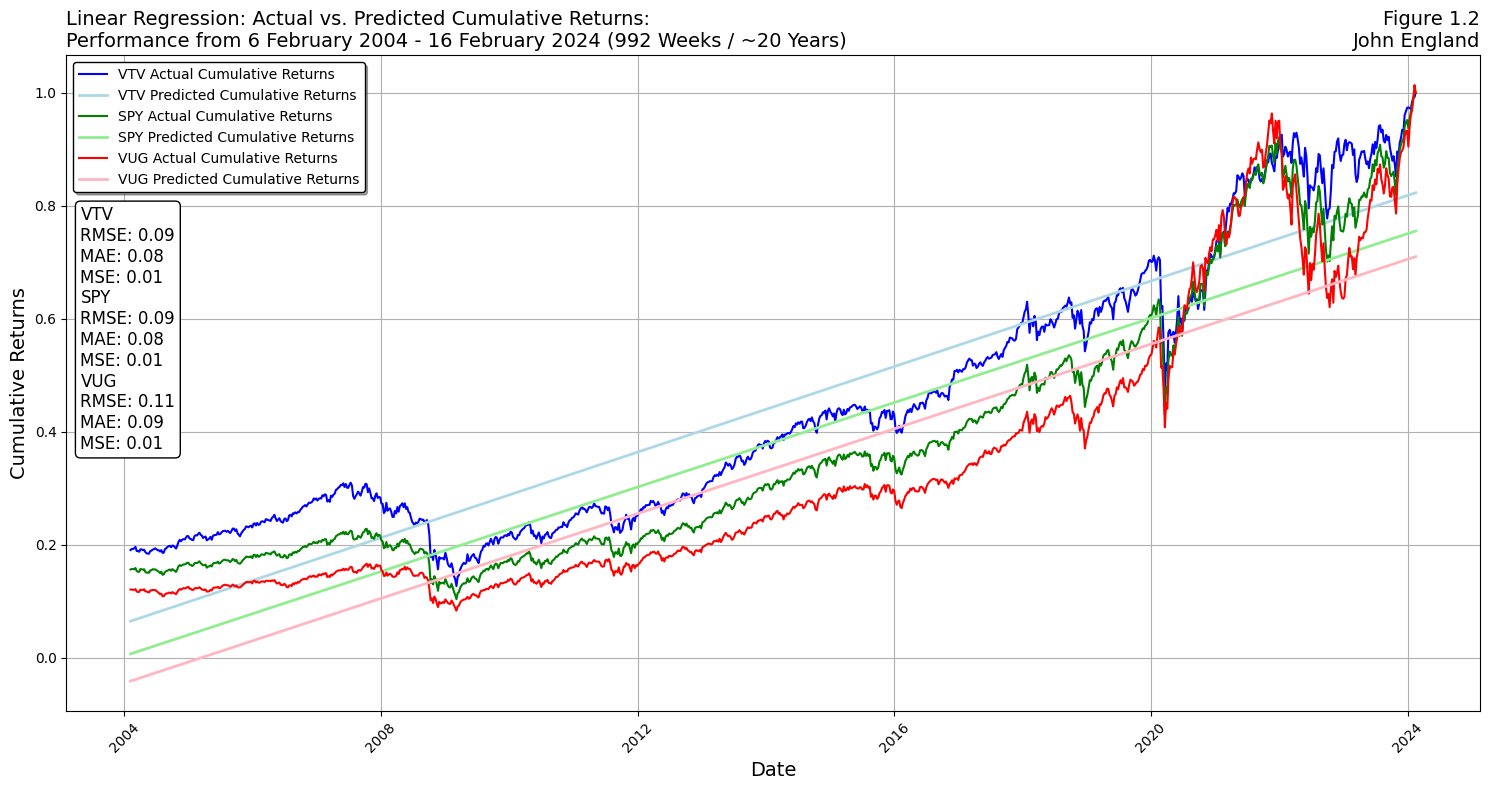

In [3]:
# Import necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def calculate_metrics(y_true, y_pred):
    """
    Calculate metrics for regression model evaluation.

    Parameters:
        y_true (array-like): Array of true target values.
        y_pred (array-like): Array of predicted target values.

    Returns:
        tuple: A tuple containing Mean Absolute Error (MAE), Mean Squared Error (MSE),
               and Root Mean Squared Error (RMSE).
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return mae, mse, rmse

# Assuming your data is stored in a DataFrame called 'cum_returns' with columns 'VTV', 'SPY', and 'VUG'
# Extracting VTV, SPY, and VUG data
vtv_data = cum_returns[['VTV']].copy()
spy_data = cum_returns[['SPY']].copy()
vug_data = cum_returns[['VUG']].copy()

# Resetting index to have date as a column
vtv_data.reset_index(inplace=True)
spy_data.reset_index(inplace=True)
vug_data.reset_index(inplace=True)

# Renaming columns for clarity
vtv_data.columns = ['date', 'cumulative_return']
spy_data.columns = ['date', 'cumulative_return']
vug_data.columns = ['date', 'cumulative_return']

# Convert date to numerical representation (seconds since Unix epoch)
vtv_data['date'] = (vtv_data['date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
spy_data['date'] = (spy_data['date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
vug_data['date'] = (vug_data['date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

# Prepare data for regression
X_vtv = vtv_data[['date']]
X_spy = spy_data[['date']]
X_vug = vug_data[['date']]

y_vtv = vtv_data['cumulative_return']
y_spy = spy_data['cumulative_return']
y_vug = vug_data['cumulative_return']

# Split data into training and testing sets
X_train_vtv, X_test_vtv, y_train_vtv, y_test_vtv = train_test_split(X_vtv, y_vtv, test_size=0.2, random_state=42)
X_train_spy, X_test_spy, y_train_spy, y_test_spy = train_test_split(X_spy, y_spy, test_size=0.2, random_state=42)
X_train_vug, X_test_vug, y_train_vug, y_test_vug = train_test_split(X_vug, y_vug, test_size=0.2, random_state=42)

# Train the linear regression model
model_vtv = LinearRegression()
model_spy = LinearRegression()
model_vug = LinearRegression()

model_vtv.fit(X_train_vtv, y_train_vtv)
model_spy.fit(X_train_spy, y_train_spy)
model_vug.fit(X_train_vug, y_train_vug)

# Predict on the full dataset
y_pred_vtv = model_vtv.predict(X_vtv)
y_pred_spy = model_spy.predict(X_spy)
y_pred_vug = model_vug.predict(X_vug)

# Convert numerical date representation back to datetime
vtv_data['date'] = pd.to_datetime(vtv_data['date'], unit='s')
spy_data['date'] = pd.to_datetime(spy_data['date'], unit='s')
vug_data['date'] = pd.to_datetime(vug_data['date'], unit='s')

# Calculate metrics for each ETF
mae_vtv, mse_vtv, rmse_vtv = calculate_metrics(y_vtv, y_pred_vtv)
mae_spy, mse_spy, rmse_spy = calculate_metrics(y_spy, y_pred_spy)
mae_vug, mse_vug, rmse_vug = calculate_metrics(y_vug, y_pred_vug)

title_font, label_font, legend_font = 14, 14, 12


# Plotting the results
plt.figure(figsize=(15, 8))
custom_colors = ['#ADD8E6','#0000FF','#90EE90','#008000','#FFB6C1','#FF0000']
plt.plot(vtv_data['date'], y_vtv, color=custom_colors[1], label='VTV Actual Cumulative Returns')
plt.plot(vtv_data['date'], y_pred_vtv, color=custom_colors[0], linewidth=2, label='VTV Predicted Cumulative Returns')
plt.plot(spy_data['date'], y_spy, color=custom_colors[3], label='SPY Actual Cumulative Returns')
plt.plot(spy_data['date'], y_pred_spy, color=custom_colors[2], linewidth=2, label='SPY Predicted Cumulative Returns')
plt.plot(vug_data['date'], y_vug, color=custom_colors[5], label='VUG Actual Cumulative Returns')
plt.plot(vug_data['date'], y_pred_vug, color=custom_colors[4], linewidth=2, label='VUG Predicted Cumulative Returns')

plt.title('Linear Regression: Actual vs. Predicted Cumulative Returns: \nPerformance from 6 February 2004 - 16 February 2024 (992 Weeks / ~20 Years)', loc = 'left', fontsize = title_font)
plt.title('Figure 1.2\nJohn England', loc = 'right', fontsize = title_font)

# Metrics as annotations
metrics_text = (
    f'VTV\nRMSE: {rmse_vtv:.2f}\nMAE: {mae_vtv:.2f}\nMSE: {mse_vtv:.2f}\n'
    f'SPY\nRMSE: {rmse_spy:.2f}\nMAE: {mae_spy:.2f}\nMSE: {mse_spy:.2f}\n'
    f'VUG\nRMSE: {rmse_vug:.2f}\nMAE: {mae_vug:.2f}\nMSE: {mse_vug:.2f}'
)
plt.annotate(metrics_text, xy=(0.01, 0.77), xycoords='axes fraction', 
             horizontalalignment='left', verticalalignment='top', fontsize=12,
             bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', alpha=1))


plt.xlabel('Date',fontsize = label_font)
plt.ylabel('Cumulative Returns', fontsize = label_font)
plt.legend(loc='upper left', frameon=True, fontsize=legend_font-2, shadow=True, edgecolor='black')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()
